##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 上的 NumPy API

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/guide/tf_numpy"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在  TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/tf_numpy.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/tf_numpy.ipynb">     <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">     在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/tf_numpy.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

## 概述

TensorFlow 实现了一部分 [NumPy API](https://numpy.org/doc/1.16)，这些 API 以 `tf.experimental.numpy` 形式提供。这样可以运行由 TensorFlow 加速的 NumPy 代码，并使用 TensorFlow 的所有 API。

## 安装


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import timeit

print("Using TensorFlow version %s" % tf.__version__)

2022-12-14 22:42:00.330214: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:42:00.330313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:42:00.330323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Using TensorFlow version 2.11.0


### 启用 NumPy 行为

要将 `tnp` 用作 NumPy，请为 TensorFlow 启用 NumPy 行为：

In [3]:
tnp.experimental_enable_numpy_behavior()

此调用可在 TensorFlow 中启用类型提升，并在将文字转换为张量时更改类型推断，以更严格地遵循 NumPy 标准。

注意：此调用将更改整个 TensorFlow 的行为，而不仅仅是 `tf.experimental.numpy` 模块。

## TensorFlow NumPy ND 数组

称为 **ND Array** 的实例 `tf.experimental.numpy.ndarray` 表示放置在特定设备上的给定 `dtype` 的多维密集数组。它是 `tf.Tensor` 的别名。请查看 ND 数组类来获取有用的方法，例如 `ndarray.T`、`ndarray.reshape`、`ndarray.ravel` 等。

首先，创建一个 ND 数组对象，然后调用不同的方法。 

In [4]:
# Create an ND array and check out different attributes.
ones = tnp.ones([5, 3], dtype=tnp.float32)
print("Created ND array with shape = %s, rank = %s, "
      "dtype = %s on device = %s\n" % (
          ones.shape, ones.ndim, ones.dtype, ones.device))

# `ndarray` is just an alias to `tf.Tensor`.
print("Is `ones` an instance of tf.Tensor: %s\n" % isinstance(ones, tf.Tensor))

# Try commonly used member functions.
print("ndarray.T has shape %s" % str(ones.T.shape))
print("narray.reshape(-1) has shape %s" % ones.reshape(-1).shape)

Created ND array with shape = (5, 3), rank = 2, dtype = <dtype: 'float32'> on device = /job:localhost/replica:0/task:0/device:GPU:0

Is `ones` an instance of tf.Tensor: True

ndarray.T has shape (3, 5)
narray.reshape(-1) has shape (15,)


### 类型提升

TensorFlow NumPy API 具有明确定义的语义，可用于将文字转换为 ND 数组，以及对 ND 数组输入执行类型提升。有关更多详细信息，请参阅 [`np.result_type`](https://numpy.org/doc/1.16/reference/generated/numpy.result_type.html)。

TensorFlow API 保持 `tf.Tensor` 输入不变并且不对其执行类型提升，而 TensorFlow NumPy API 则根据 NumPy 类型提升规则来提升所有输入。在下一个示例中，您将执行类型提升。首先，对不同类型的 ND 数组输入运行加法并记下输出类型。TensorFlow API 不允许这些类型提升。

In [5]:
print("Type promotion for operations")
values = [tnp.asarray(1, dtype=d) for d in
          (tnp.int32, tnp.int64, tnp.float32, tnp.float64)]
for i, v1 in enumerate(values):
  for v2 in values[i + 1:]:
    print("%s + %s => %s" % 
          (v1.dtype.name, v2.dtype.name, (v1 + v2).dtype.name))

Type promotion for operations
int32 + int64 => int64
int32 + float32 => float64
int32 + float64 => float64
int64 + float32 => float64
int64 + float64 => float64
float32 + float64 => float64


最后，使用 `ndarray.asarray` 将文字转换为 ND 数组，并记录结果类型。

In [6]:
print("Type inference during array creation")
print("tnp.asarray(1).dtype == tnp.%s" % tnp.asarray(1).dtype.name)
print("tnp.asarray(1.).dtype == tnp.%s\n" % tnp.asarray(1.).dtype.name)

Type inference during array creation
tnp.asarray(1).dtype == tnp.int64
tnp.asarray(1.).dtype == tnp.float64



将文字转换为 ND 数组时，NumPy 倾向于使用 `tnp.int64` 和 `tnp.float64` 之类的宽类型。相反，`tf.convert_to_tensor` 则倾向于使用 `tf.int32` 和 `tf.float32` 类型将常量转换为 `tf.Tensor`。TensorFlow NumPy API 遵循整数的 NumPy 行为。对于浮点数，`experimental_enable_numpy_behavior` 的 `prefer_float32` 参数可让您控制倾向于使用 `tf.float32` 而不是 `tf.float64`（默认为 `False`）。例如：

In [7]:
tnp.experimental_enable_numpy_behavior(prefer_float32=True)
print("When prefer_float32 is True:")
print("tnp.asarray(1.).dtype == tnp.%s" % tnp.asarray(1.).dtype.name)
print("tnp.add(1., 2.).dtype == tnp.%s" % tnp.add(1., 2.).dtype.name)

tnp.experimental_enable_numpy_behavior(prefer_float32=False)
print("When prefer_float32 is False:")
print("tnp.asarray(1.).dtype == tnp.%s" % tnp.asarray(1.).dtype.name)
print("tnp.add(1., 2.).dtype == tnp.%s" % tnp.add(1., 2.).dtype.name)

When prefer_float32 is True:
tnp.asarray(1.).dtype == tnp.float32
tnp.add(1., 2.).dtype == tnp.float32
When prefer_float32 is False:
tnp.asarray(1.).dtype == tnp.float64
tnp.add(1., 2.).dtype == tnp.float64


### 广播

与 TensorFlow 类似，NumPy 为“广播”值定义了丰富的语义。您可以查看 [NumPy 广播指南](https://numpy.org/doc/stable/user/basics.broadcasting.html)了解更多信息，还可将其与 [TensorFlow 广播语义](https://tensorflow.google.cn/guide/tensor#broadcasting)进行比较。

In [8]:
x = tnp.ones([2, 3])
y = tnp.ones([3])
z = tnp.ones([1, 2, 1])
print("Broadcasting shapes %s, %s and %s gives shape %s" % (
    x.shape, y.shape, z.shape, (x + y + z).shape))

Broadcasting shapes (2, 3), (3,) and (1, 2, 1) gives shape (1, 2, 3)


### 索引

NumPy 定义了非常复杂的索引规则。请参阅 [NumPy 索引指南](https://numpy.org/doc/1.16/reference/arrays.indexing.html)。请注意，下面的示例将 ND 数组用作索引。

In [9]:
x = tnp.arange(24).reshape(2, 3, 4)

print("Basic indexing")
print(x[1, tnp.newaxis, 1:3, ...], "\n")

print("Boolean indexing")
print(x[:, (True, False, True)], "\n")

print("Advanced indexing")
print(x[1, (0, 0, 1), tnp.asarray([0, 1, 1])])

Basic indexing
tf.Tensor(
[[[16 17 18 19]
  [20 21 22 23]]], shape=(1, 2, 4), dtype=int64) 

Boolean indexing
tf.Tensor(
[[[ 0  1  2  3]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [20 21 22 23]]], shape=(2, 2, 4), dtype=int64) 

Advanced indexing
tf.Tensor([12 13 17], shape=(3,), dtype=int64)


In [10]:
# Mutation is currently not supported
try:
  tnp.arange(6)[1] = -1
except TypeError:
  print("Currently, TensorFlow NumPy does not support mutation.")

Currently, TensorFlow NumPy does not support mutation.


### 示例模型

接下来，您将看到如何创建一个模型并在该模型上运行推断。此简单模型应用 ReLU 层，随后是线性投影。后面的部分将展示如何使用 TensorFlow 的 `GradientTape` 计算此模型的梯度。

In [11]:
class Model(object):
  """Model with a dense and a linear layer."""

  def __init__(self):
    self.weights = None

  def predict(self, inputs):
    if self.weights is None:
      size = inputs.shape[1]
      # Note that type `tnp.float32` is used for performance.
      stddev = tnp.sqrt(size).astype(tnp.float32)
      w1 = tnp.random.randn(size, 64).astype(tnp.float32) / stddev
      bias = tnp.random.randn(64).astype(tnp.float32)
      w2 = tnp.random.randn(64, 2).astype(tnp.float32) / 8
      self.weights = (w1, bias, w2)
    else:
      w1, bias, w2 = self.weights
    y = tnp.matmul(inputs, w1) + bias
    y = tnp.maximum(y, 0)  # Relu
    return tnp.matmul(y, w2)  # Linear projection

model = Model()
# Create input data and compute predictions.
print(model.predict(tnp.ones([2, 32], dtype=tnp.float32)))

tf.Tensor(
[[0.12651756 0.06182817]
 [0.12651756 0.06182817]], shape=(2, 2), dtype=float32)


## TensorFlow NumPy 和 NumPy

TensorFlow NumPy 实现了完整 NumPy 规范的子集。尽管随着时间的推移会添加更多符号，但一些系统功能在不久的将来将不再受支持。这些功能包括 NumPy C API 支持、Swig 集成、Fortran 存储顺序、视图和 `stride_tricks` 以及一些 `dtype`（例如 `np.recarray`、`np.object`）。有关更多详细信息，请参阅 [TensorFlow NumPy API 文档](https://tensorflow.google.cn/api_docs/python/tf/experimental/numpy)。


### NumPy 互操作性

TensorFlow ND 数组可与 NumPy 函数互操作。这些对象实现了 `__array__` 接口。NumPy 使用此接口先将函数参数转换为 `np.ndarray` 值，然后再对它们进行处理。

同样，TensorFlow NumPy 函数可以接受不同类型的输入，包括 `np.ndarray`。通过在它们上面调用 `ndarray.asarray` 可将这些输入转换为 ND 数组。

ND 数组与 `np.ndarray` 之间的转换可能会触发实际数据副本。有关更多详细信息，请参阅关于[缓冲区副本](#Buffer-copies)的部分。

In [12]:
# ND array passed into NumPy function.
np_sum = np.sum(tnp.ones([2, 3]))
print("sum = %s. Class: %s" % (float(np_sum), np_sum.__class__))

# `np.ndarray` passed into TensorFlow NumPy function.
tnp_sum = tnp.sum(np.ones([2, 3]))
print("sum = %s. Class: %s" % (float(tnp_sum), tnp_sum.__class__))

sum = 6.0. Class: <class 'numpy.float64'>
sum = 6.0. Class: <class 'tensorflow.python.framework.ops.EagerTensor'>


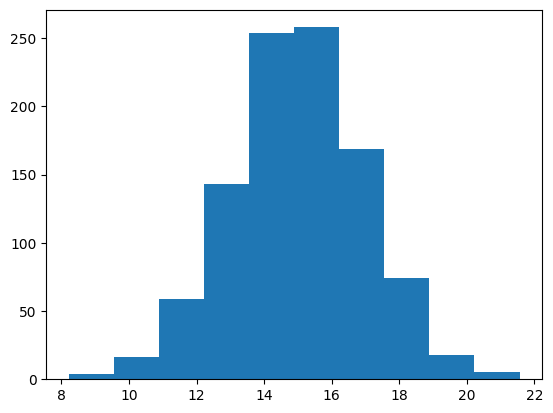

In [13]:
# It is easy to plot ND arrays, given the __array__ interface.
labels = 15 + 2 * tnp.random.randn(1, 1000)
_ = plt.hist(labels)

### 缓冲区副本

混合使用 TensorFlow NumPy 与 NumPy 代码可能会触发数据副本。这是因为 TensorFlow NumPy 对内存对齐的要求比 NumPy 更严格。

当 `np.ndarray` 传递给 TensorFlow NumPy 时，它将检查对齐要求，并在需要时触发副本。将 ND 数组 CPU 缓冲区传递给 NumPy 时，该缓冲区通常会满足对齐要求，并且 NumPy 无需创建副本。

ND 数组可以引用放置在本地 CPU 内存以外设备上的缓冲区。在这种情况下，调用 NumPy 函数将根据需要触发网络或设备上的副本。

有鉴于此，与 NumPy API 调用混合使用时通常应谨慎操作，并且用户应当注意复制数据的开销。将 TensorFlow NumPy 调用与 TensorFlow 调用交错通常是安全的，可避免复制数据。有关更多详细信息，请参阅关于 [Tensorflow 互操作性](#tensorflow-interoperability)的部分。

### 算子优先级

TensorFlow NumPy 定义了一个优先级高于 NumPy 的 `__array_priority__`。这意味着，对于同时涉及 ND 数组和 `np.ndarray` 的算子，前者将获得优先权，即 `np.ndarray` 输入将转换为 ND 数组，并且将调用该算子的 TensorFlow NumPy 实现。

In [14]:
x = tnp.ones([2]) + np.ones([2])
print("x = %s\nclass = %s" % (x, x.__class__))

x = tf.Tensor([2. 2.], shape=(2,), dtype=float64)
class = <class 'tensorflow.python.framework.ops.EagerTensor'>


## TF NumPy 和 TensorFlow

TensorFlow NumPy 在 TensorFlow 上构建，因此可与 TensorFlow 无缝互操作。

### `tf.Tensor` 和 ND 数组

ND 数组是 `tf.Tensor` 的别名，因此显然可以在不触发实际数据副本的情况下将它们混合到一起。

In [15]:
x = tf.constant([1, 2])
print(x)

# `asarray` and `convert_to_tensor` here are no-ops.
tnp_x = tnp.asarray(x)
print(tnp_x)
print(tf.convert_to_tensor(tnp_x))

# Note that tf.Tensor.numpy() will continue to return `np.ndarray`.
print(x.numpy(), x.numpy().__class__)

tf.Tensor([1 2], shape=(2,), dtype=int32)
tf.Tensor([1 2], shape=(2,), dtype=int32)
tf.Tensor([1 2], shape=(2,), dtype=int32)
[1 2] <class 'numpy.ndarray'>


### TensorFlow 互操作性

ND 数组可以传递给 TensorFlow API，因为 ND 数组只是 `tf.Tensor` 的别名。如上文所述，即使是放置在加速器或远程设备上的数据，这种互操作也不会创建数据副本。

相反，可以将 `tf.Tensor` 对象传递给 `tf.experimental.numpy` API，而无需执行数据副本。

In [16]:
# ND array passed into TensorFlow function.
tf_sum = tf.reduce_sum(tnp.ones([2, 3], tnp.float32))
print("Output = %s" % tf_sum)

# `tf.Tensor` passed into TensorFlow NumPy function.
tnp_sum = tnp.sum(tf.ones([2, 3]))
print("Output = %s" % tnp_sum)

Output = tf.Tensor(6.0, shape=(), dtype=float32)
Output = tf.Tensor(6.0, shape=(), dtype=float32)


### 梯度和雅可比矩阵：tf.GradientTape

TensorFlow 的 GradientTape 可通过 TensorFlow 和 TensorFlow NumPy 代码用于反向传播。

使用在[示例模型](#example-modle)部分中创建的模型，并计算梯度和雅可比矩阵。

In [17]:
def create_batch(batch_size=32):
  """Creates a batch of input and labels."""
  return (tnp.random.randn(batch_size, 32).astype(tnp.float32),
          tnp.random.randn(batch_size, 2).astype(tnp.float32))

def compute_gradients(model, inputs, labels):
  """Computes gradients of squared loss between model prediction and labels."""
  with tf.GradientTape() as tape:
    assert model.weights is not None
    # Note that `model.weights` need to be explicitly watched since they
    # are not tf.Variables.
    tape.watch(model.weights)
    # Compute prediction and loss
    prediction = model.predict(inputs)
    loss = tnp.sum(tnp.square(prediction - labels))
  # This call computes the gradient through the computation above.
  return tape.gradient(loss, model.weights)

inputs, labels = create_batch()
gradients = compute_gradients(model, inputs, labels)

# Inspect the shapes of returned gradients to verify they match the
# parameter shapes.
print("Parameter shapes:", [w.shape for w in model.weights])
print("Gradient shapes:", [g.shape for g in gradients])
# Verify that gradients are of type ND array.
assert isinstance(gradients[0], tnp.ndarray)

Parameter shapes:

 [TensorShape([32, 64]), TensorShape([64]), TensorShape([64, 2])]
Gradient shapes: [TensorShape([32, 64]), TensorShape([64]), TensorShape([64, 2])]


In [18]:
# Computes a batch of jacobians. Each row is the jacobian of an element in the
# batch of outputs w.r.t. the corresponding input batch element.
def prediction_batch_jacobian(inputs):
  with tf.GradientTape() as tape:
    tape.watch(inputs)
    prediction = model.predict(inputs)
  return prediction, tape.batch_jacobian(prediction, inputs)

inp_batch = tnp.ones([16, 32], tnp.float32)
output, batch_jacobian = prediction_batch_jacobian(inp_batch)
# Note how the batch jacobian shape relates to the input and output shapes.
print("Output shape: %s, input shape: %s" % (output.shape, inp_batch.shape))
print("Batch jacobian shape:", batch_jacobian.shape)

Output shape: (16, 2), input shape: (16, 32)
Batch jacobian shape: (16, 2, 32)


### 跟踪编译：tf.function

TensorFlow 的 `tf.function` 的工作方式是先“跟踪编译”代码，然后优化这些跟踪记录来提高性能。请参阅[计算图和函数简介](./intro_to_graphs.ipynb)。

`tf.function` 也可用于优化 TensorFlow NumPy 代码。下面是一个演示加速的简单示例。请注意， `tf.function` 代码的主体包括对 TensorFlow NumPy API 的调用。


In [19]:
inputs, labels = create_batch(512)
print("Eager performance")
compute_gradients(model, inputs, labels)
print(timeit.timeit(lambda: compute_gradients(model, inputs, labels),
                    number=10) * 100, "ms")

print("\ntf.function compiled performance")
compiled_compute_gradients = tf.function(compute_gradients)
compiled_compute_gradients(model, inputs, labels)  # warmup
print(timeit.timeit(lambda: compiled_compute_gradients(model, inputs, labels),
                    number=10) * 100, "ms")

Eager performance


2.366622199951962 ms

tf.function compiled performance
0.5858368998815422 ms


### 向量化：tf.vectorized_map

TensorFlow 内置对向量化并行循环的支持，可以将速度提高一到两个数量级。这些加速可通过 `tf.vectorized_map`  API 访问，并且也适用于 TensorFlow NumPy 代码。

有时，计算一个批次中每个输出相对于相应的输入批次元素的梯度十分有用。可以使用 `tf.vectorized_map` 有效地完成此类计算，具体如下所示。

In [20]:
@tf.function
def vectorized_per_example_gradients(inputs, labels):
  def single_example_gradient(arg):
    inp, label = arg
    return compute_gradients(model,
                             tnp.expand_dims(inp, 0),
                             tnp.expand_dims(label, 0))
  # Note that a call to `tf.vectorized_map` semantically maps
  # `single_example_gradient` over each row of `inputs` and `labels`.
  # The interface is similar to `tf.map_fn`.
  # The underlying machinery vectorizes away this map loop which gives
  # nice speedups.
  return tf.vectorized_map(single_example_gradient, (inputs, labels))

batch_size = 128
inputs, labels = create_batch(batch_size)

per_example_gradients = vectorized_per_example_gradients(inputs, labels)
for w, p in zip(model.weights, per_example_gradients):
  print("Weight shape: %s, batch size: %s, per example gradient shape: %s " % (
      w.shape, batch_size, p.shape))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Weight shape: (32, 64), batch size: 128, per example gradient shape: (128, 32, 64) 
Weight shape: (64,), batch size: 128, per example gradient shape: (128, 64) 
Weight shape: (64, 2), batch size: 128, per example gradient shape: (128, 64, 2) 


In [21]:
# Benchmark the vectorized computation above and compare with
# unvectorized sequential computation using `tf.map_fn`.
@tf.function
def unvectorized_per_example_gradients(inputs, labels):
  def single_example_gradient(arg):
    inp, label = arg
    return compute_gradients(model,
                             tnp.expand_dims(inp, 0),
                             tnp.expand_dims(label, 0))

  return tf.map_fn(single_example_gradient, (inputs, labels),
                   fn_output_signature=(tf.float32, tf.float32, tf.float32))

print("Running vectorized computation")
print(timeit.timeit(lambda: vectorized_per_example_gradients(inputs, labels),
                    number=10) * 100, "ms")

print("\nRunning unvectorized computation")
per_example_gradients = unvectorized_per_example_gradients(inputs, labels)
print(timeit.timeit(lambda: unvectorized_per_example_gradients(inputs, labels),
                    number=10) * 100, "ms")

Running vectorized computation


0.587835499936773 ms

Running unvectorized computation


29.57804869984102 ms


### 设备放置

TensorFlow NumPy 可以将运算置于 CPU、GPU、TPU 和远程设备上。它使用标准的 TensorFlow 机制完成设备放置。下面我们将给出一个简单的示例，先列出所有设备，然后在特定设备上放置一些计算。

TenorFlow 还具有用于在设备之间复制计算并执行集体缩减的 API，这里不作介绍。

#### 列出设备

可以使用 `tf.config.list_logical_devices` 和 `tf.config.list_physical_devices` 查找要使用的设备。

In [22]:
print("All logical devices:", tf.config.list_logical_devices())
print("All physical devices:", tf.config.list_physical_devices())

# Try to get the GPU device. If unavailable, fallback to CPU.
try:
  device = tf.config.list_logical_devices(device_type="GPU")[0]
except IndexError:
  device = "/device:CPU:0"

All logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU'), LogicalDevice(name='/device:GPU:2', device_type='GPU'), LogicalDevice(name='/device:GPU:3', device_type='GPU')]
All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


#### 放置运算：**`tf.device`**

通过在 `tf.device` 范围内调用设备，可以将运算放置在该设备上。


In [23]:
print("Using device: %s" % str(device))
# Run operations in the `tf.device` scope.
# If a GPU is available, these operations execute on the GPU and outputs are
# placed on the GPU memory.
with tf.device(device):
  prediction = model.predict(create_batch(5)[0])

print("prediction is placed on %s" % prediction.device)

Using device: LogicalDevice(name='/device:GPU:0', device_type='GPU')
prediction is placed on /job:localhost/replica:0/task:0/device:GPU:0


#### 跨设备复制 ND 数组：**`tnp.copy`**

调用位于某个设备范围内的 `tnp.copy` 会将数据复制到该设备，除非这些数据已存在于该设备上。

In [24]:
with tf.device("/device:CPU:0"):
  prediction_cpu = tnp.copy(prediction)
print(prediction.device)
print(prediction_cpu.device)

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:CPU:0


## 性能比较

TensorFlow NumPy 使用高度优化的 TensorFlow 内核，这些内核可在 CPU、GPU 和 TPU 上调度。TensorFlow 还执行许多编译器优化（如运算融合），这些优化可转化为性能和内存改进。要了解更多信息，请参阅[使用 Grappler 进行 TensorFlow 计算图优化](./guide/graph_optimization)。

但是，与 NumPy 相比，TensorFlow 在调度运算上的开销更高。对于由小型运算（短于约 10 微秒）组成的工作负载，这些开销会占用大部分运行时，此时，NumPy 可以提供更好的性能。对于其他情况，TensorFlow 通常会提供更好的性能。

运行以下基准测试来比较 NumPy 和 TensorFlow NumPy 在不同输入大小下的性能。

In [25]:
def benchmark(f, inputs, number=30, force_gpu_sync=False):
  """Utility to benchmark `f` on each value in `inputs`."""
  times = []
  for inp in inputs:
    def _g():
      if force_gpu_sync:
        one = tnp.asarray(1)
      f(inp)
      if force_gpu_sync:
        with tf.device("CPU:0"):
          tnp.copy(one)  # Force a sync for GPU case

    _g()  # warmup
    t = timeit.timeit(_g, number=number)
    times.append(t * 1000. / number)
  return times


def plot(np_times, tnp_times, compiled_tnp_times, has_gpu, tnp_times_gpu):
  """Plot the different runtimes."""
  plt.xlabel("size")
  plt.ylabel("time (ms)")
  plt.title("Sigmoid benchmark: TF NumPy vs NumPy")
  plt.plot(sizes, np_times, label="NumPy")
  plt.plot(sizes, tnp_times, label="TF NumPy (CPU)")
  plt.plot(sizes, compiled_tnp_times, label="Compiled TF NumPy (CPU)")
  if has_gpu:
    plt.plot(sizes, tnp_times_gpu, label="TF NumPy (GPU)")
  plt.legend()

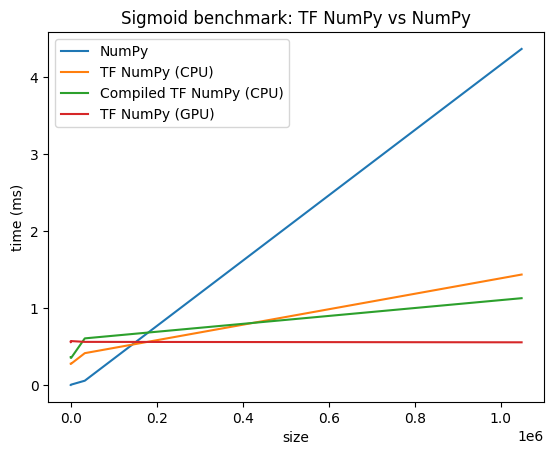

In [26]:
# Define a simple implementation of `sigmoid`, and benchmark it using
# NumPy and TensorFlow NumPy for different input sizes.

def np_sigmoid(y):
  return 1. / (1. + np.exp(-y))

def tnp_sigmoid(y):
  return 1. / (1. + tnp.exp(-y))

@tf.function
def compiled_tnp_sigmoid(y):
  return tnp_sigmoid(y)

sizes = (2 ** 0, 2 ** 5, 2 ** 10, 2 ** 15, 2 ** 20)
np_inputs = [np.random.randn(size).astype(np.float32) for size in sizes]
np_times = benchmark(np_sigmoid, np_inputs)

with tf.device("/device:CPU:0"):
  tnp_inputs = [tnp.random.randn(size).astype(np.float32) for size in sizes]
  tnp_times = benchmark(tnp_sigmoid, tnp_inputs)
  compiled_tnp_times = benchmark(compiled_tnp_sigmoid, tnp_inputs)

has_gpu = len(tf.config.list_logical_devices("GPU"))
if has_gpu:
  with tf.device("/device:GPU:0"):
    tnp_inputs = [tnp.random.randn(size).astype(np.float32) for size in sizes]
    tnp_times_gpu = benchmark(compiled_tnp_sigmoid, tnp_inputs, 100, True)
else:
  tnp_times_gpu = None
plot(np_times, tnp_times, compiled_tnp_times, has_gpu, tnp_times_gpu)

## 延伸阅读

- [TensorFlow NumPy：分布式图像分类教程](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/numpy_ops/g3doc/TensorFlow_Numpy_Distributed_Image_Classification.ipynb)
- [TensorFlow NumPy：Keras 和分布策略](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/numpy_ops/g3doc/TensorFlow_NumPy_Keras_and_Distribution_Strategy.ipynb)
- [使用 Trax 和 TensorFlow NumPy 进行情感分析](https://github.com/google/trax/blob/master/trax/tf_numpy_and_keras.ipynb)